In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import BertModel
from torch.optim import RAdam

2025-05-30 21:19:16.119362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748639956.306693      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748639956.363098      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define constants
LABEL_NUM = 2
SEQ_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load dataset
data_files = {"train": "train/train.csv", "test": "test/test.csv"}
dataset = load_dataset(path="/kaggle/input/review-dataset", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BERTTextCNN(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=2, dropout_rate=0.2):
        super(BERTTextCNN, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout_rate)

        self.filter_sizes = [2, 3, 4, 5]
        self.num_filters = 256
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=self.bert.config.hidden_size,
                      out_channels=self.num_filters,
                      kernel_size=fs)
            for fs in self.filter_sizes
        ])

        self.fc = nn.Linear(len(self.filter_sizes) * self.num_filters, 256)
        self.output = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = self.dropout(bert_out)  # [batch_size, seq_len, hidden_size]

        x = x.permute(0, 2, 1)  # [batch_size, hidden_size, seq_len] for Conv1d

        conv_results = []
        for conv in self.convs:
            c = torch.relu(conv(x))  # [batch_size, num_filters, L_out]
            p = nn.functional.max_pool1d(c, kernel_size=c.shape[2])  # [batch_size, num_filters, 1]
            conv_results.append(p.squeeze(2))  # [batch_size, num_filters]

        cat = torch.cat(conv_results, dim=1)  # [batch_size, num_filters * len(filter_sizes)]
        cat = self.fc(cat)
        logits = self.output(cat)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels.long())  # Ensure labels are LongTensor with values 0 or 1
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}


In [5]:
# Initialize model
model = BERTTextCNN(num_labels=LABEL_NUM).to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
# Define encoder
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=SEQ_LEN)

In [7]:
# Data tokenization
training_set = dataset['train'].map(tokenize_function, batched=True)
testing_set = dataset['test'].map(tokenize_function, batched=True)

# Format torch
training_set.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
testing_set.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/30256 [00:00<?, ? examples/s]

Map:   0%|          | 0/7576 [00:00<?, ? examples/s]

In [8]:
# Training stage

# Load GPU if had
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load data by DataLoader
train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
# Load optimizer
optimizer = torch.optim.RAdam(model.parameters(), lr=LR)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

100%|██████████| 1891/1891 [13:41<00:00,  2.30it/s]


Epoch 1, Loss: 0.3333500534481217


100%|██████████| 1891/1891 [13:40<00:00,  2.30it/s]


Epoch 2, Loss: 0.23274588437247598


100%|██████████| 1891/1891 [13:41<00:00,  2.30it/s]


Epoch 3, Loss: 0.19619331492868555


100%|██████████| 1891/1891 [13:41<00:00,  2.30it/s]


Epoch 4, Loss: 0.1643317372307658


100%|██████████| 1891/1891 [13:41<00:00,  2.30it/s]

Epoch 5, Loss: 0.13201225883059503


In [9]:
# Testing stage 
test_dataloader = DataLoader(testing_set, batch_size=BATCH_SIZE)

predictions = []
true_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

100%|██████████| 474/474 [00:54<00:00,  8.72it/s]


In [10]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(true_labels, predictions, digits=3))
print("Accuracy:", accuracy_score(true_labels, predictions))
print("Precision:", precision_score(true_labels, predictions))
print("Recall:", recall_score(true_labels, predictions))
print("F1-Score:", f1_score(true_labels, predictions))

              precision    recall  f1-score   support

           0      0.904     0.926     0.915      3748
           1      0.926     0.904     0.915      3828

    accuracy                          0.915      7576
   macro avg      0.915     0.915     0.915      7576
weighted avg      0.915     0.915     0.915      7576

Accuracy: 0.9147307286166843
Precision: 0.9258565310492506
Recall: 0.9036050156739812
F1-Score: 0.914595452141724


In [11]:
from sklearn.metrics import confusion_matrix

# y_true: true labels
# y_pred: predicted labels
cm = confusion_matrix(true_labels, predictions)
cm

array([[3471,  277],
       [ 369, 3459]])

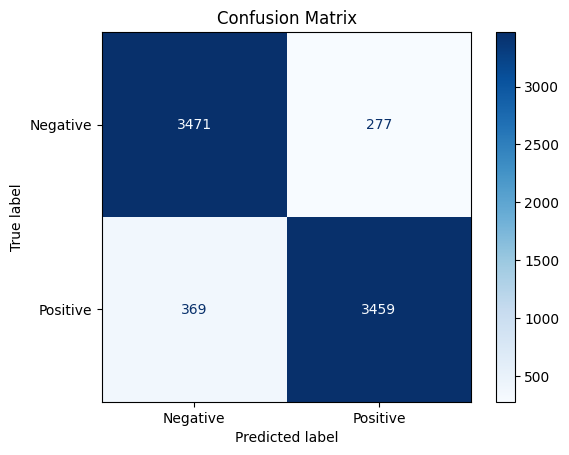

In [12]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()